# 1. Imports

In [23]:
import sys
sys.path.append('..')

import os
import json
import random
import math
import pydicom
import cv2
import glob
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
import torch

from dataset import PreprocessedDataset
from utils.data_analysis import analyze_dataset

plt.style.use('default')
sns.set_palette("husl")

# 2. Data pre-processing and visualization

Function lo load, pre-process and generate 3 representations from a DICOM example

In [10]:
def convert_file_to_3channel(dcm_path, toImageNet=False, output_size=(224, 224), mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    # Loading the file data
    ds = pydicom.dcmread(dcm_path)
    # Loading the pixel values
    img = ds.pixel_array.astype(np.float32)
    # Converting to Hounsfield Units (HU)
    intercept = float(ds.RescaleIntercept)
    slope = float(ds.RescaleSlope)
    hu = img * slope + intercept
    # Defining the window presets
    # brain, subdural and bone
    windows = [(40, 80), (80, 200), (600, 2800)]
    # Windowing the images according to the three presets
    channels = []
    for center, width in windows:
        mn = center - width // 2
        mx = center + width // 2
        win = np.clip(hu, mn, mx)
        # Normalizing to [0, 1]
        norm = (win - mn) / (mx - mn)
        # Resizing to the output size
        if toImageNet:
            norm = cv2.resize(norm, output_size, interpolation=cv2.INTER_LINEAR)
        channels.append(norm)
    # Stacking into (3, H, W)
    three_chan = np.stack(channels, axis=0).astype(np.float32)
    # Applying ImageNet normalization
    if toImageNet:
        mean_values = np.array(mean, dtype=np.float32).reshape(3, 1, 1)
        std_values = np.array(std, dtype=np.float32).reshape(3, 1, 1)
        three_chan = (three_chan - mean_values) / std_values
    return three_chan

Function to order the slices

In [11]:
def get_z_position(fpath):
    # Reading each data file
    dcm = pydicom.dcmread(fpath, stop_before_pixels=True)
    # Extrcating the image position patient data which provides the z-axis (depth / sequencial) position
    pos = dcm.ImagePositionPatient
    if pos is not None:
        # Returning the depth coordinate
        return float(pos[2])
    else:
        # If the depth coordinate is not present then appending it to the end
        return float('inf')

Function to view all the 3 channels for multiple triplets

In [12]:
def display_triplets(triplets_data, triplets_per_row=4):
    # Calculating the number of rows and columns needed
    num_triplets = len(triplets_data)
    num_rows = math.ceil(num_triplets/triplets_per_row)
    # Plotting for each row
    for row_number in range(num_rows):
        row_triplets_data = triplets_data[row_number*triplets_per_row:(row_number+1)*triplets_per_row]
        fig, axes = plt.subplots(3, triplets_per_row*3, figsize=(triplets_per_row * 7.5, 7.5))
        plt.subplots_adjust(wspace=0.05, hspace=0.05)
        # Sweeping over all the row triplet data
        for i, triplet in enumerate(row_triplets_data):
            triplet_slices = triplet['slices']
            triplet_label = triplet['label']
            # Ordering the data
            triplet_slices_sorted = sorted(triplet_slices, key=get_z_position)
            # Calculating the triplet's position in the grid
            triplet_col = i % triplets_per_row
            # Looping over each triplet
            for slice_idx in range(3):
                dcm_path = triplet_slices_sorted[slice_idx]
                # Processing the DICOM file to get 3 channels
                three_chan_img = convert_file_to_3channel(dcm_path, toImageNet=True)
                # Viewing the three channels per slice
                for channel_idx in range(3):
                    # Viewing the data
                    ax = axes[slice_idx, triplet_col * 3 + channel_idx]
                    ax.imshow(three_chan_img[channel_idx, :, :], cmap='gray')
                    if slice_idx == 0 and channel_idx == 1:
                        ax.set_title(f'|--------------Label: {triplet_label}--------------|', fontsize=20, pad=10)
                    ax.axis('off')
        plt.show()


Visualize all the three channels for one triplet per class

In [25]:
data_dir = '../triplets/'
with open('../triplets/labels.json', 'r') as f:
    data_label = json.load(f)
triplets_data = []
preprocessed_data_dir = '../DL_Project_Processed_Data/'

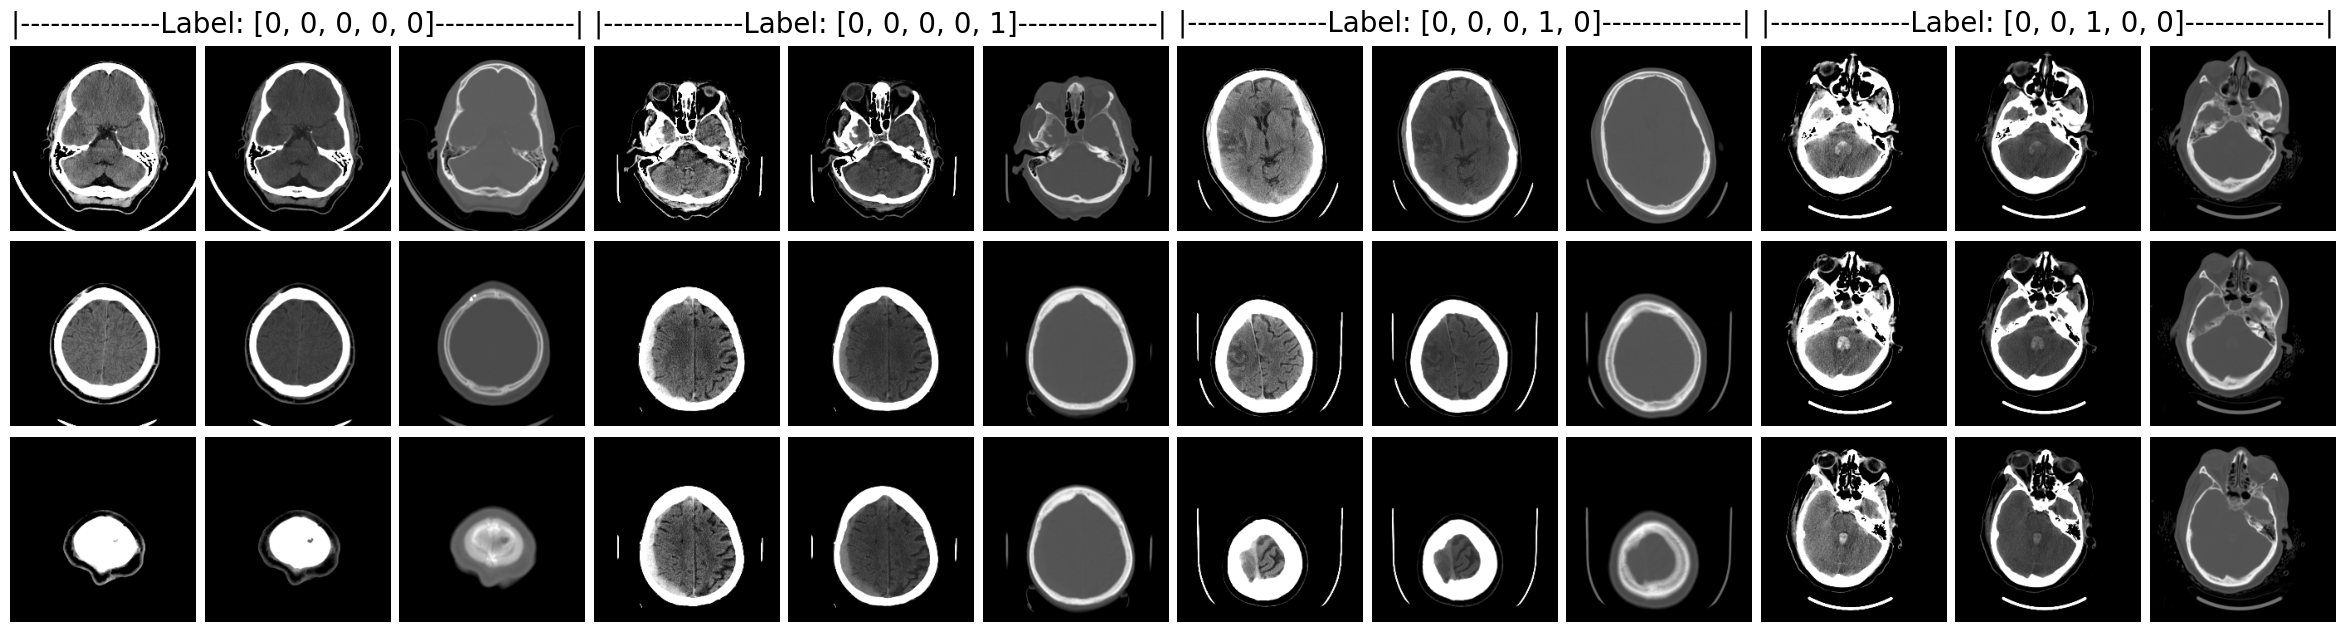

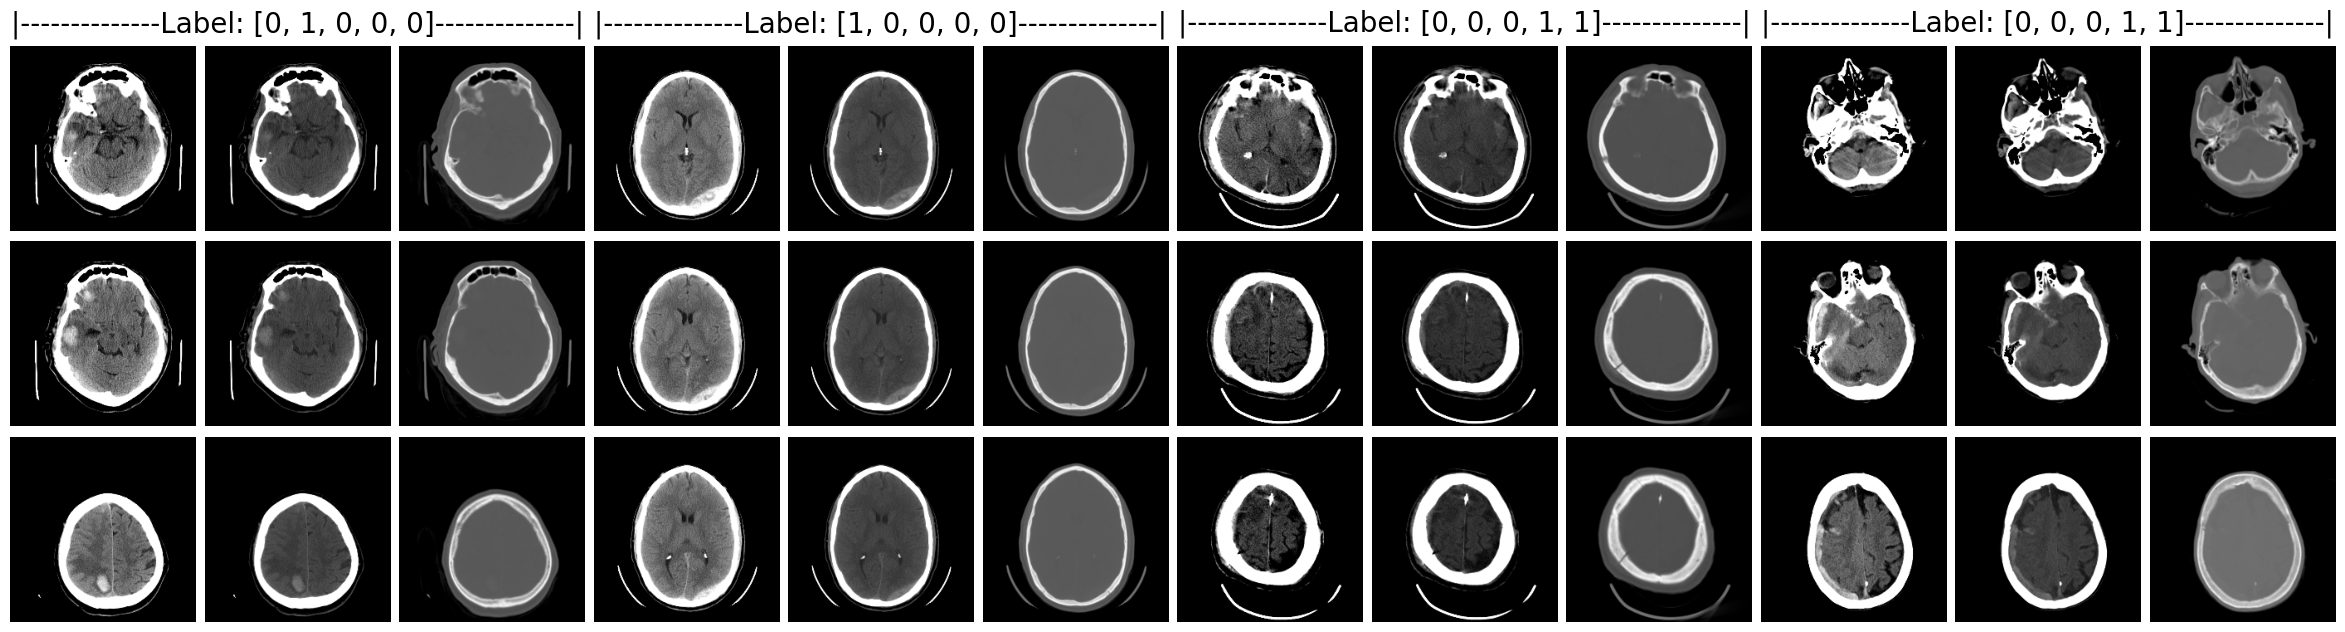

In [21]:
# Listing all folders in the data directory
folders = [f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))]
folders = sorted(folders)
# As we want two examples from the multiple class
folders.append(folders[-1])

# Initializing the randomly selected data list as an empty list
triplets_data = []

# Looping over each folder
for folder_name in folders:
    folder_path = os.path.join(data_dir, folder_name)
    # Listing all the sub-folder in the folder
    sub_folders = [f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f))]
    # Randomly choosing a sub-folder
    selected_sub_folder = random.choice(sub_folders)
    # Taking the files from the chosen sub-folder
    selected_files = os.listdir(os.path.join(folder_path, selected_sub_folder))
    # Extracting the label
    label = data_label[selected_sub_folder]
    # Placing the selected data in a dictionary
    triplet_dict = {
        'slices': [os.path.join(folder_path, selected_sub_folder, f) for f in selected_files],
        'label': label
    }
    # Appending the dictionary to the list
    triplets_data.append(triplet_dict)

# Visualizing the results
display_triplets(triplets_data, triplets_per_row=4)

Create dicom series dataset

In [24]:
class DicomSubSeriesDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        # Initializing the parameters
        self.root_dir = root_dir
        self.transform = transform
        # Getting a list of all subdirectories for each group containing tiplet folders
        self.triplet_folders = [f.path for f in os.scandir(root_dir)  if f.is_dir() ]
        self.labels = data_label
    def __len__(self):
        return len(self.triplet_folders)
    def __getitem__(self, idx):
        triplet_folder = self.triplet_folders[idx]
        triplet_id = os.path.basename(triplet_folder)
        # Finding all .dcm files in the folder
        dicom_files = glob(os.path.join(triplet_folder, '*.dcm'))
        # Ordering the data
        dicom_files_sorted = sorted(dicom_files, key=get_z_position)
        # Reading the DICOM files, applying 3-channel windowing and stacking their pixel arrays
        images = []
        for file_path in dicom_files_sorted:
            channels = convert_file_to_3channel(file_path)
            images.append(channels)
        # Stack the images into a single pytorch tensor of shape (9, H, W)
        image_stack = torch.from_numpy(np.concatenate(images))
        # Applying the transfomrs
        if self.transform:
            image_stack = self.transform(image_stack)
        # Generating the labels / targets
        labels = self.labels[triplet_id]
        labels = torch.tensor(labels)
        return image_stack, triplet_folder, labels

Pre-processing the data

In [26]:
if not os.path.exists(preprocessed_data_dir):
    # Defining the transforms
    img_size = 224
    transforms = transforms.Compose(
        [
            transforms.Resize(size=(img_size, img_size), antialias=True),
            transforms.Normalize(mean=[0.485, 0.456, 0.406] * 3, std=[0.229, 0.224, 0.225] * 3),
        ]
    )
    # Pre-processing the data
    for group in os.scandir(data_dir):
        if not group.is_dir():
            continue
        print(f'Processing group: {group.name}')
        dataset = DicomSubSeriesDataset(root_dir=group.path, transform=transforms)
        # Defining the train, val and test split size
        dataset_size = len(dataset)
        train_size = int(0.8 * dataset_size)
        val_size = int(0.1 * dataset_size)
        test_size = dataset_size - train_size - val_size
        print(f'Total dataset size: {dataset_size}')
        print(f'Training set size: {train_size}')
        print(f'Validation set size: {val_size}')
        print(f'Test set size: {test_size}')
        # Splitting the data
        train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
        for folder, subset in [('train', train_dataset), ('val', val_dataset), ('test', test_dataset)]:
            # Creating the new destination path
            destination_folder = os.path.join(preprocessed_data_dir, folder, group.name)
            os.makedirs(destination_folder, exist_ok=True)
            # Saving and storing the data
            for i in tqdm(range(len(subset))):
                image_tensor, triplet_folder, label = subset[i]
                relative_path = os.path.relpath(triplet_folder, dataset.root_dir)
                destination_file = os.path.join(destination_folder, relative_path + '.pt')
                torch.save((image_tensor, label), destination_file)
    # Zipping the data
    !zip -rq "$drive_preprocessed_data_dir" .
else:
    print('Data already pre-processed')

Data already pre-processed


# 3. Analyze preprocessed data

In [3]:
analysis_results = analyze_dataset('../DL_Project_Processed_Data')


DATASET ANALYSIS

Total Samples: 2285
Unique Class Combinations: 26

Per-Class Distribution:
Class                       Positive   Negative      Pos %    Imbalance
--------------------------------------------------------------------------------
epidural                         112       2173      4.90%       19.40:1
intraparenchymal                 570       1715     24.95%        3.01:1
intraventricular                 500       1785     21.88%        3.57:1
subarachnoid                     636       1649     27.83%        2.59:1
subdural                         587       1698     25.69%        2.89:1
--------------------------------------------------------------------------------

Multi-Label Statistics:
  Samples with 0 labels (healthy): 500 (21.88%)
  Samples with 1 label:            1285 (56.24%)
  Samples with 2+ labels:          500 (21.88%)
  Average labels per sample:       1.05

Top 10 Class Combinations:
Combination                              Count   Percentage
---------

In [5]:
train_dataset = PreprocessedDataset(root_dir='../DL_Project_Processed_Data/train')

class_names = ['Epidural', 'Intraparenchymal', 'Intraventricular', 'Subarachnoid', 'Subdural']

# Find samples for each class
samples_to_show = {}
for idx in range(len(train_dataset)):
    _, label = train_dataset[idx]
    label_tuple = tuple(label)
    
    # Healthy sample
    if label_tuple == (0, 0, 0, 0, 0) and 'healthy' not in samples_to_show:
        samples_to_show['healthy'] = idx
    
    # Single hemorrhage samples
    for i in range(5):
        single_label = [0] * 5
        single_label[i] = 1
        if label_tuple == tuple(single_label) and class_names[i].lower() not in samples_to_show:
            samples_to_show[class_names[i].lower()] = idx
    
    if len(samples_to_show) >= 6:
        break

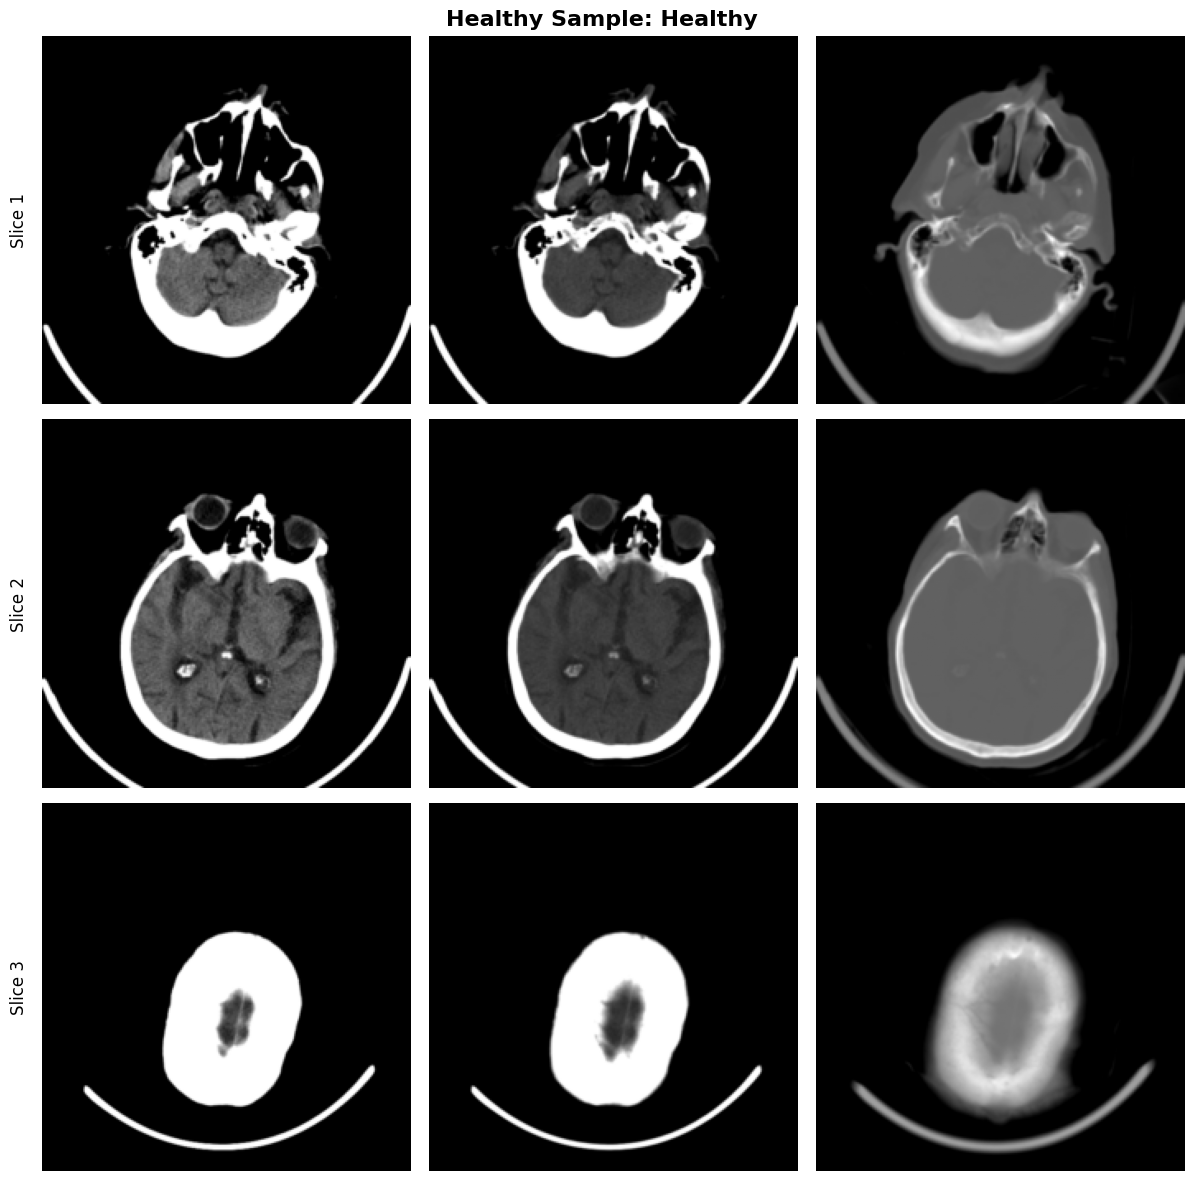

In [8]:
# Visualize the 9 channels (3 slices × 3 window presets)
def visualize_sample(dataset, idx, title="Sample"):
    image, label = dataset[idx]
    
    # image shape: (9, 224, 224)
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    
    for slice_idx in range(3):
        for window_idx in range(3):
            channel_idx = slice_idx * 3 + window_idx
            ax = axes[slice_idx, window_idx]
            ax.imshow(image[channel_idx], cmap='gray')
            ax.axis('off')
            
            # Add titles
            if window_idx == 0:
                ax.text(-20, 112, f'Slice {slice_idx + 1}', 
                       rotation=90, va='center', fontsize=12)
    
    # Add overall title with label
    label_str = ', '.join([class_names[i] for i, val in enumerate(label) if val == 1])
    if not label_str:
        label_str = 'Healthy'
    
    fig.suptitle(f'{title}: {label_str}', fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()

# Visualize a healthy sample
if 'healthy' in samples_to_show:
    visualize_sample(train_dataset, samples_to_show['healthy'], "Healthy Sample")


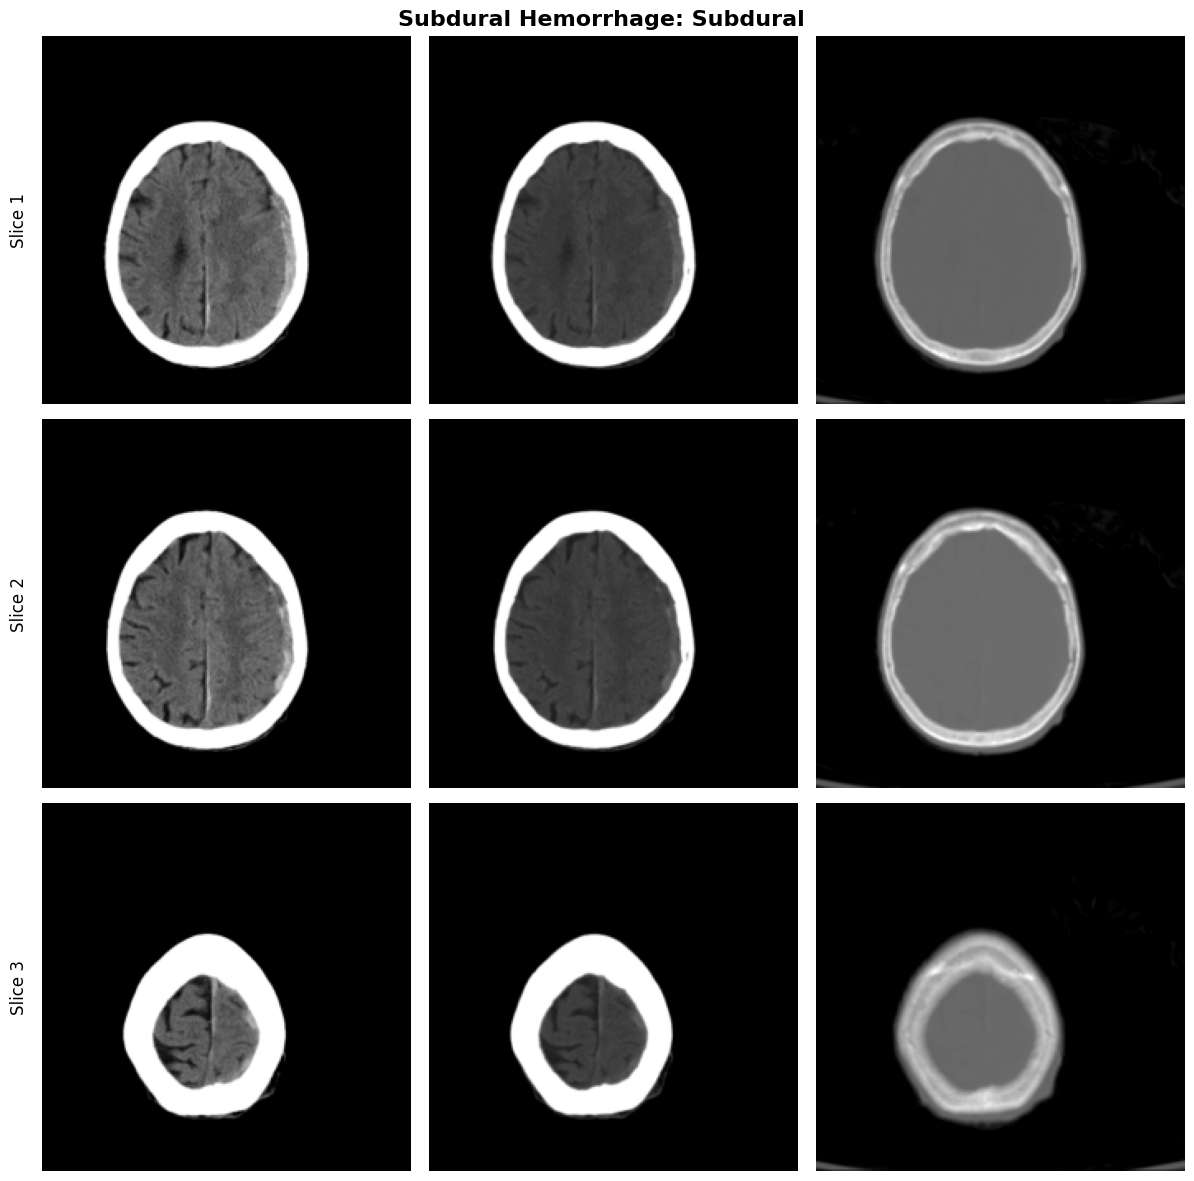

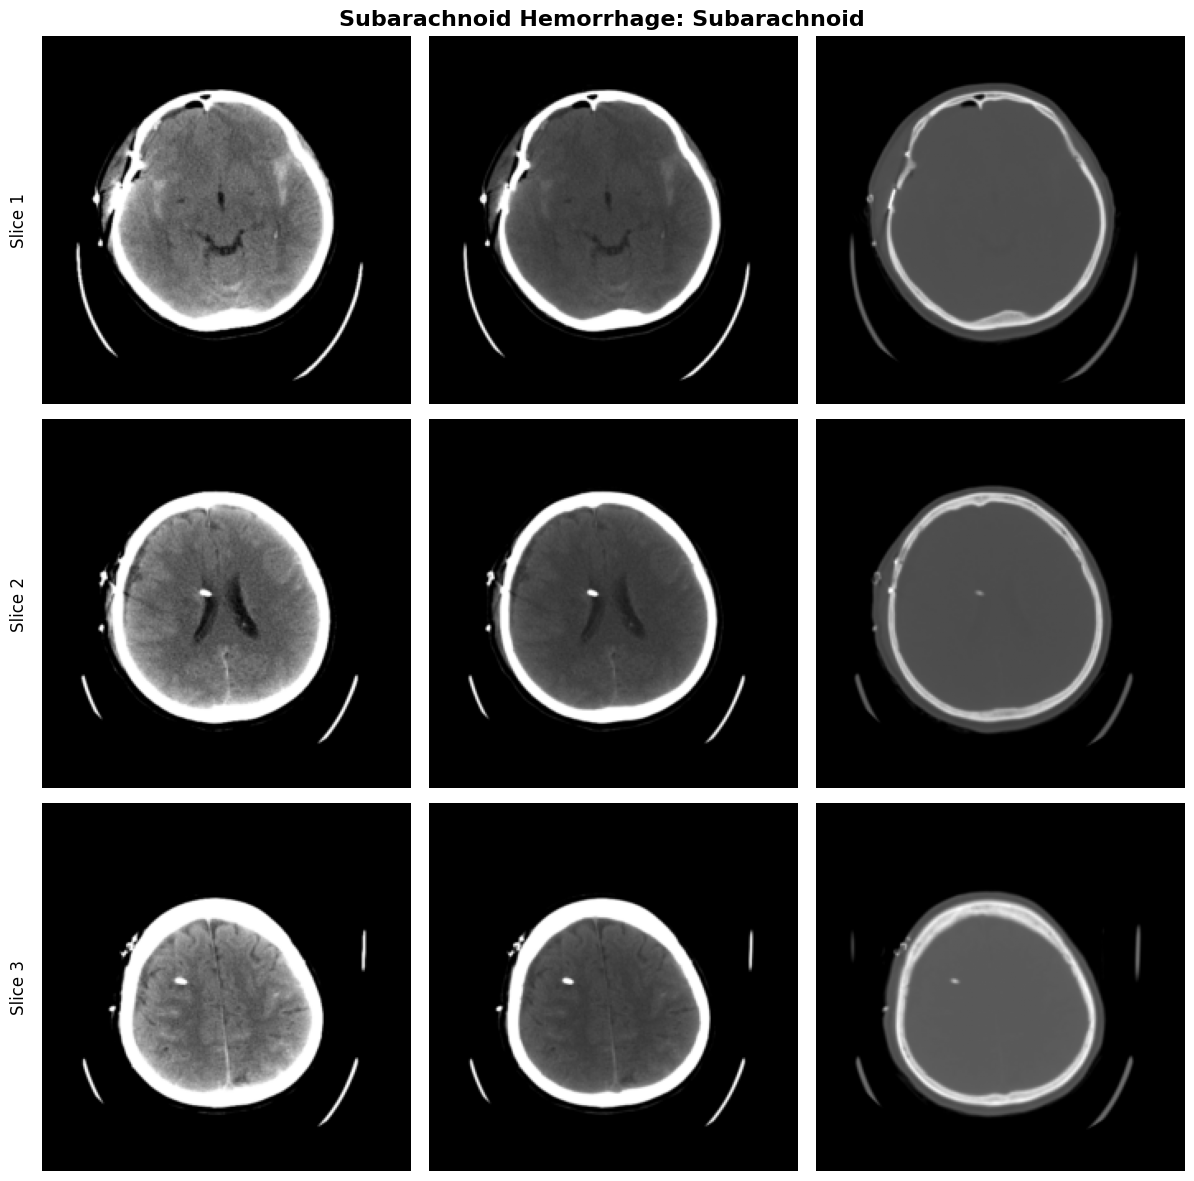

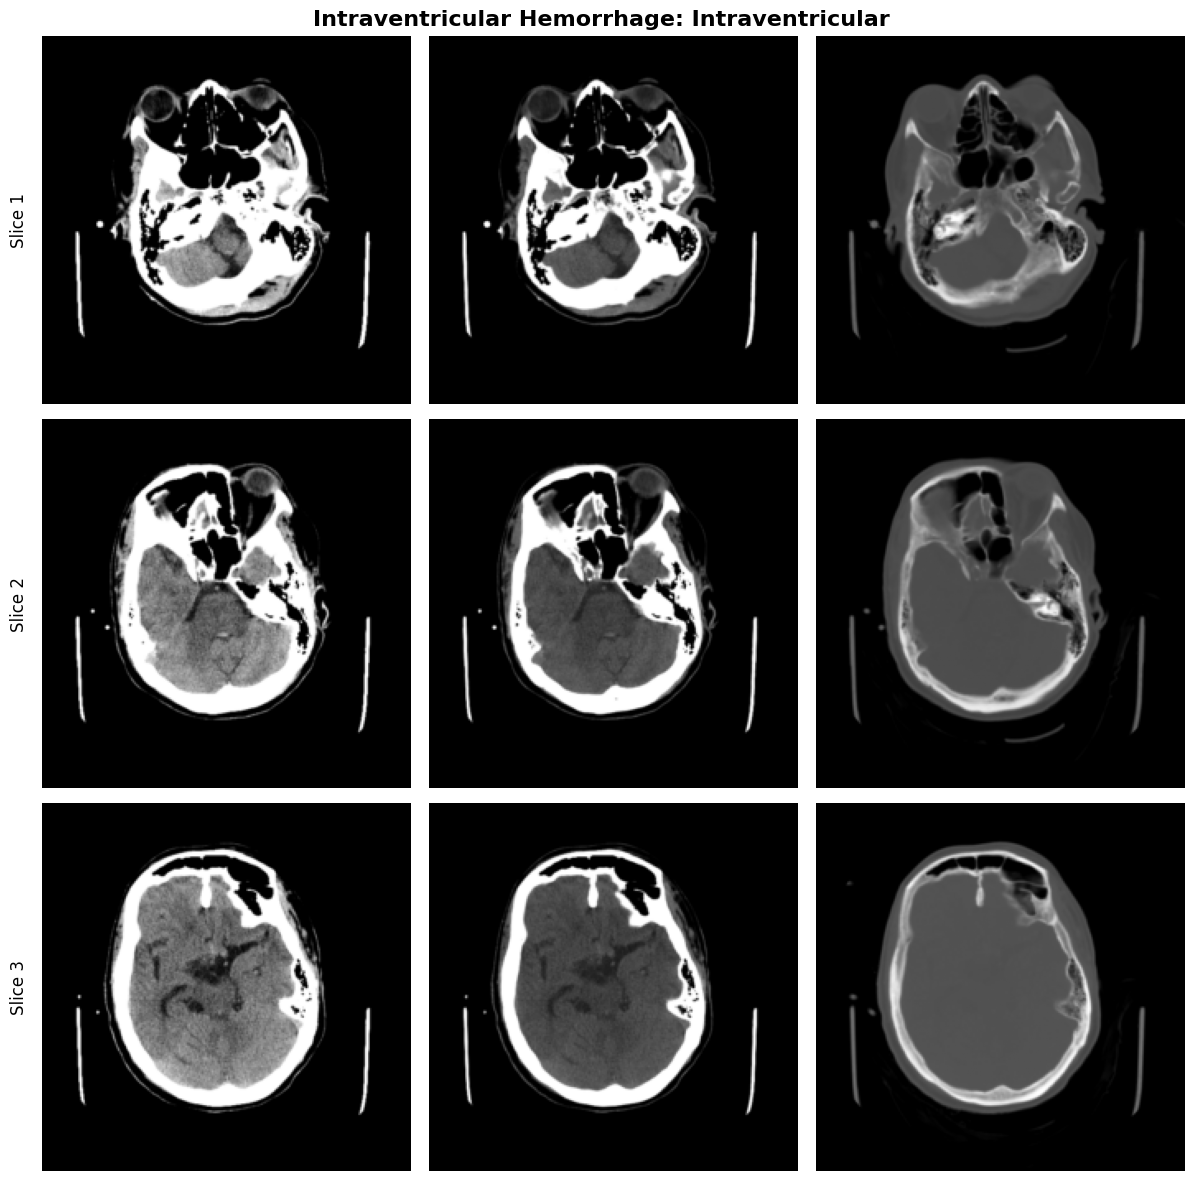

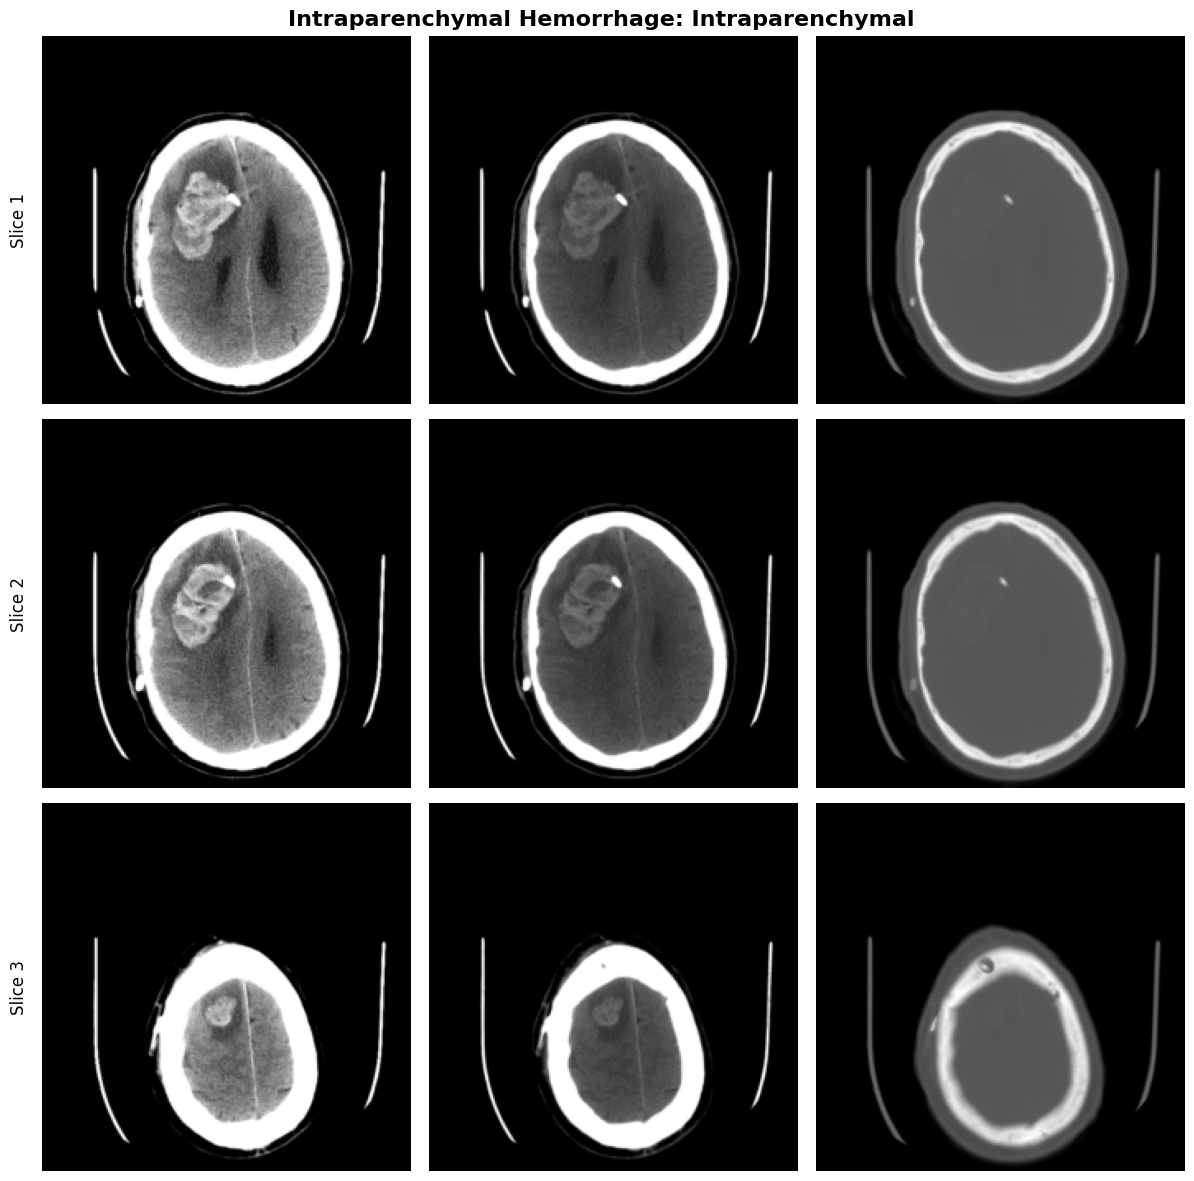

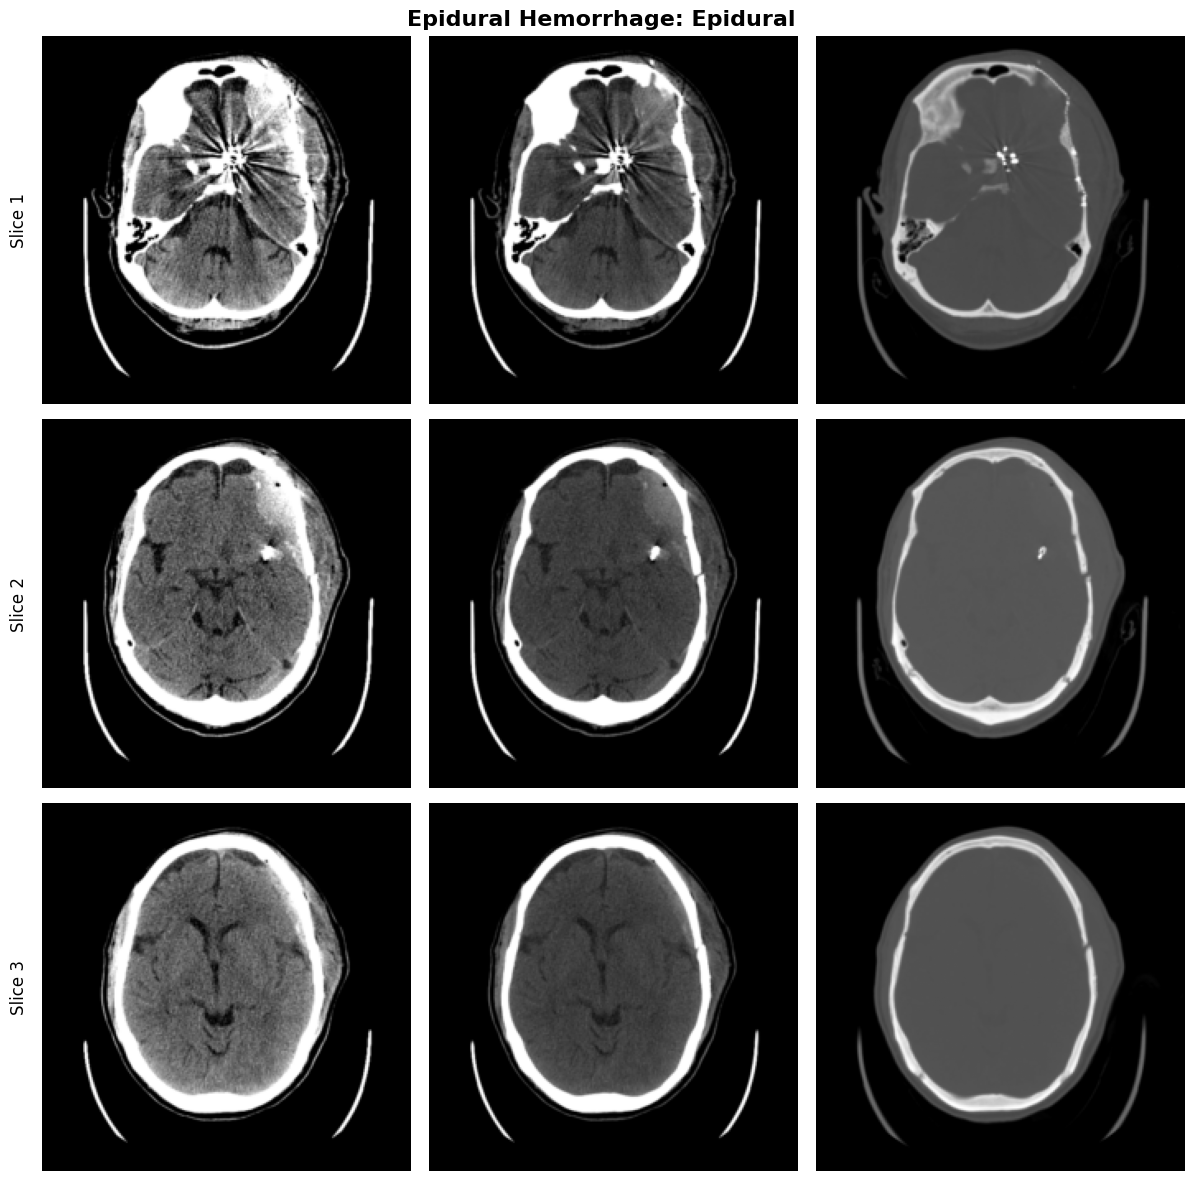

In [9]:
for class_type, idx in samples_to_show.items():
    if class_type != 'healthy':
        visualize_sample(train_dataset, idx, f"{class_type.capitalize()} Hemorrhage")
